# Обработка ЯМР спектров в python при помощи библиотеки nmrglue

* [сайт библиотеки](https://www.nmrglue.com/)
* [Документация](https://nmrglue.readthedocs.io/en/latest/index.html)

импортируем используемые библиотеки

In [1]:
import nmrglue as ng
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Загрузим папку с данными. Нужна целая директория со всеми сопутствующими файлами.

Проведём аподизацию и фурье преобразования. Для шумных спектров гуминовых веществ lb нужно задать порядка 0.0002-0.001. 

In [2]:
# загружаем папку с данными
dic, data = ng.bruker.read('data')

# стандартная процедура очистки спектров брукер от цифрового фильтра
data = ng.bruker.remove_digital_filter(dic, data)

# загружаем шкалу ppm
udic = ng.bruker.guess_udic(dic, data)
uc = ng.fileiobase.uc_from_udic(udic)
ppm_scale = uc.ppm_scale()

data = ng.proc_base.em(data, lb=0.001)         # exponent apodization - уменьшить lb для увеличения разрешения
data = ng.proc_base.fft(data)               # Fourier transform

Фазировать спектры гуминовых веществ автоматически получается плохо, поэтому вручную

In [4]:
# автофазирование
# data = ng.proc_autophase.autops(data, 'acme', p0=0.0, p1=0)

# ручное фазирование
data = ng.proc_autophase.manual_ps(data, notebook=True)

interactive(children=(FloatSlider(value=-0.0015926535897929917, description='phcorr0', max=3.141592653589793, …

Внесём найденные после ручного фазирования коэффициенты и внесем их функцию фазирования. Также включим в обработку функцию удаления мнимых частей и развернём данные в привчные вид - от больших ppm к меньшим

Перед загрузкой нужно перезагрузить блок с предварительной загрузкой и обработкой спектра

In [3]:
data = ng.proc_base.ps(data, p0=-193, p1=319)      # фазирование - подставляем найденные значения после ручного фазирования
data = ng.proc_base.di(data)                # discard the imaginaries
data = ng.proc_base.rev(data)               # reverse the data

Построим спектр

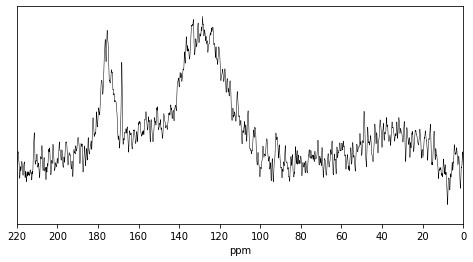

In [4]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ppm_scale, data, linewidth=0.5, c='black')
ax.set_xlabel('ppm')
ax.set_yticks([])
ax.set_xticks(np.arange(0, 221, step=20))
ax.set_xlim(220, 0)
plt.savefig('C13_nmr.png', dpi=150)

Создадим Dataframe на основе данных

In [5]:
df = pd.DataFrame(data=[], columns=['ppm', 'I'])
df['ppm'] = ppm_scale
df['I'] = data

Посчитаем интегралы

In [6]:
#зададим интервалы интегрирования
int_tuple = (220, 185, 170, 165, 135, 120, 110, 60, 30, 0)

#нормализуем данные в заданном интервале
df = df.loc[(df['ppm'] <= int_tuple[0]) & (df['ppm'] >= int_tuple[-1])]
df['I'] /= df['I'].sum()

int_dict = pd.DataFrame(data=[], columns=['range', 'integral'])
for i in range(0, len(int_tuple)-1, 1):
    name = f'{int_tuple[i]}-{int_tuple[i+1]}'
    integral = df.loc[(df['ppm'] <= int_tuple[i]) & (df['ppm'] >= int_tuple[i+1])]['I'].sum()
    int_dict.loc[int_dict.shape[0]] = [name, integral]


Сохраним спектр и интегралы в excel файле

In [7]:
df = df.set_index('ppm')
int_dict = int_dict.set_index('range')

with pd.ExcelWriter('output.xlsx') as writer:  
    df.to_excel(writer, sheet_name='spec')
    int_dict.to_excel(writer, sheet_name='integrals')